In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 1: Input the processed data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data testing with IDXExchange/data_filtered-6nd-log_ClosePrice.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79543 entries, 0 to 79542
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AttachedGarageYN           79543 non-null  float64
 1   BathroomsTotalInteger      79543 non-null  float64
 2   BedroomsTotal              79543 non-null  float64
 3   FireplaceYN                79543 non-null  float64
 4   GarageSpaces               79543 non-null  float64
 5   Latitude                   79543 non-null  float64
 6   LivingArea                 79543 non-null  float64
 7   Longitude                  79543 non-null  float64
 8   LotSizeSquareFeet          79543 non-null  float64
 9   NewConstructionYN          79543 non-null  float64
 10  ParkingTotal               79543 non-null  float64
 11  PoolPrivateYN              79543 non-null  float64
 12  Stories                    79543 non-null  float64
 13  ViewYN                     79543 non-null  flo

### Train-Test Split

**Features/Target:**  
- `X`: All features except `log_ClosePrice`  
- `y`: Transformed target (`log_ClosePrice`)  

**Split:**  
80% train / 20% test  
- Random state fixed (42) for reproducibility  

**Purpose:**  
Creates evaluation framework for model development  

In [ ]:
X = data.drop(['log_ClosePrice'], axis=1)
y = data['log_ClosePrice']

In [ ]:
# Step 2: Random train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Modeling Pipeline

**Components:**
1. `StandardScaler`: Normalizes all features  
2. `RandomForestRegressor`:  
   - 30 trees (`n_estimators=30`)  
   - Fixed random state (`42`) for reproducibility  

**Design:**  
Single pipeline ensures:  
- Consistent preprocessing for train/test  
- Avoids data leakage  
- Simplified model deployment  

In [ ]:
# Step 3: Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=30, random_state=42))
])

### Model Validation

**Method:**  
5-fold cross-validation with:  
- Shuffled splits (`shuffle=True`)  
- Fixed random state (`42`)  

**Metrics Reported:**  
- **RMSE**:  
  `{mean:.2f} ± {std:.2f}`  
- **MAE**:  
  `{mean:.2f}`  
- **R²**:  
  `{mean:.4f}`  

**Purpose:**  
Robust performance estimation before final test evaluation

In [ ]:
# Step 4: Cross-validation on training set
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
mse_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

print("Cross-validated RMSE scores on Training Set:", rmse_scores)
print(f"Average RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

Cross-validated RMSE scores on Training Set: [0.21286903 0.18018384 0.17441161 0.18330647 0.17211637]
Average RMSE: 0.18
Standard Deviation of RMSE: 0.01


In [ ]:
# Optional: Other metrics
scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

In [ ]:
results = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=scoring)

print(f"MAE scores: {results['test_mae']}")
print(f"Average MAE: {np.mean(results['test_mae']):.2f}")

print(f"RMSE scores: {np.sqrt(results['test_mse'])}")
print(f"Average RMSE: {np.mean(np.sqrt(results['test_mse'])):.2f}")

print(f"R² scores: {results['test_r2']}")
print(f"Average R²: {np.mean(results['test_r2']):.4f}")

MAE scores: [0.11683174 0.1169057  0.11387609 0.11552286 0.11511504]
Average MAE: 0.12
RMSE scores: [0.21286903 0.18018384 0.17441161 0.18330647 0.17211637]
Average RMSE: 0.18
R² scores: [0.84315796 0.88446971 0.88799685 0.88116587 0.89167799]
Average R²: 0.8777


### Final Model Evaluation

**Process:**
1. Trained pipeline on full training set  
2. Predicted on held-out test set  

**Test Metrics:**  
- **MAE**: `{value:.4f}`  
- **MSE**: `{value:.4f}`
- **RMSE**: `{value:.4f}`  
- **R²**: `{value:.4f}`  

**Purpose:**  
Unbiased performance estimate of production-ready model  

In [ ]:
# Step 5: Final model training and evaluation on test set
pipeline.fit(X_train, y_train)
y_pred_test = pipeline.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n--- Final Evaluation on Test Set ---")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R² Score: {r2_test:.4f}")


--- Final Evaluation on Test Set ---
MAE: 0.1131
MSE: 0.0295
RMSE: 0.1718
R² Score: 0.8907


### Prediction Visualization

**Plot Components:**  
- Points: Actual vs Predicted values (`log_ClosePrice`)  
- Red line: Perfect prediction reference  

**Key Insights:**  
- Vertical spread shows prediction error magnitude  
- Cloud tightness indicates model accuracy  
- Outliers visible as distant points  

**Purpose:**  
Visual diagnostic beyond numeric metrics

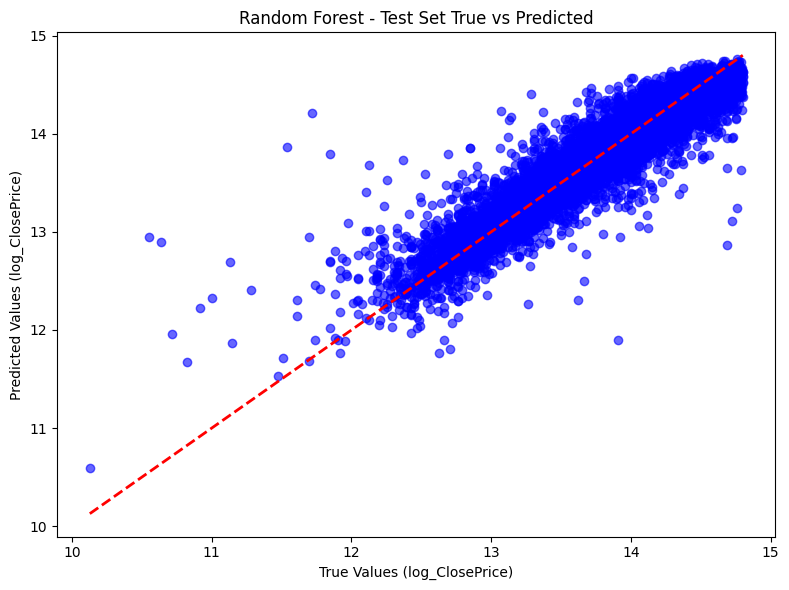

In [ ]:
# Step 6: Plot True vs Predicted on Test Set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('True Values (log_ClosePrice)')
plt.ylabel('Predicted Values (log_ClosePrice)')
plt.title('Random Forest - Test Set True vs Predicted')
plt.tight_layout()
plt.show()

### USD Price Prediction Plot

**Transformation:**  
Converted predictions from log-scale back to original USD prices  

**Key Features:**  
- Points show actual vs predicted home values  
- Red line represents perfect predictions  
- Axes now in interpretable USD  

**Business Value:**  
Enables direct evaluation of dollar-value accuracy

In [ ]:
# Convert from log scale back to original price scale
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred_test)

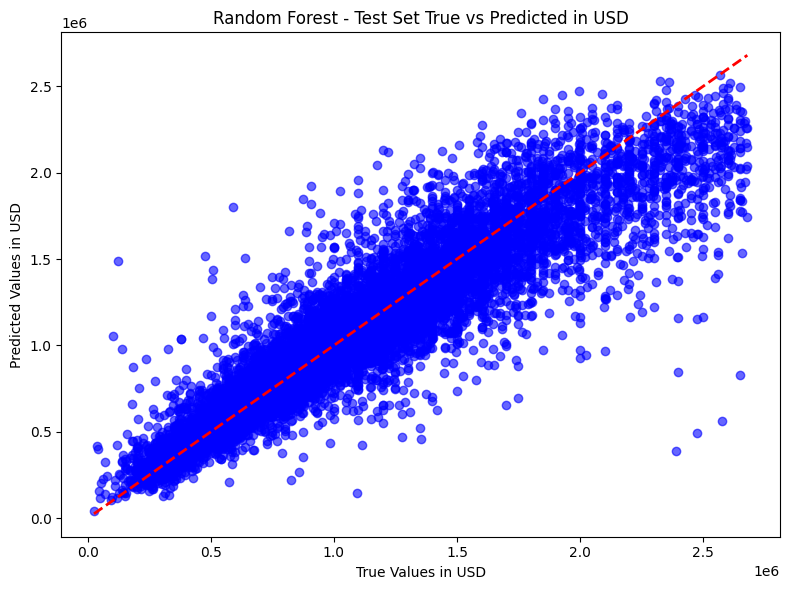

In [ ]:
# Step 6: Plot True vs Predicted on Test Set
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred_actual, color='blue', alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--', lw=2)
plt.xlabel('True Values in USD')
plt.ylabel('Predicted Values in USD')
plt.title('Random Forest - Test Set True vs Predicted in USD')
plt.tight_layout()
plt.show()